In [1]:
# import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
# intialisation des paramètres (learning rate, nombre des epochs et batch size)
INIT_LR = 1e-3
EPOCHS = 25
BS = 8
# liste des images
imagePaths = list(paths.list_images("dataset"))

In [3]:
data = []
labels = []

for imagePath in imagePaths:
    # extraire la classe d'image
    label = imagePath.split(os.path.sep)[-2]
    
    # chargez et redimensionnez l'image 224x244
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # mis à jour des listes
    data.append(image)
    labels.append(label)

In [4]:
# convertir data et labels en NumPy array
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

In [5]:
# l'encodage des labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [6]:
# partitionner les données (80% pour l'entrainemet et 20% pour le test)
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [7]:
# augmentation des données d'entrainemet
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [8]:
# charger le réseau VGG16 sans la derniere chouche
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [9]:
# construire la derniere chouche du model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [10]:
# placez la couche sur le modèle de base (cela deviendra le modèle réel que nous allons former)
model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
# freeze les couche du modèle de base pour n'être pas mis à jour lors du premier processus d'entrainemet
for layer in baseModel.layers:
    layer.trainable = False

In [12]:
# compiler notre modèle
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [13]:
# entrener le head de notre réseau
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
5/5 [==============================] - 281s 56s/step - loss: 0.7468 - accuracy: 0.6000 - val_loss: 0.7029 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 310s 62s/step - loss: 0.7711 - accuracy: 0.4500 - val_loss: 0.6497 - val_accuracy: 0.8000
Epoch 3/25
5/5 [==============================] - 308s 62s/step - loss: 0.6505 - accuracy: 0.6000 - val_loss: 0.6374 - val_accuracy: 0.7000
Epoch 4/25
5/5 [==============================] - 325s 65s/step - loss: 0.6558 - accuracy: 0.6250 - val_loss: 0.6151 - val_accuracy: 0.8000
Epoch 5/25
5/5 [==============================] - 312s 62s/step - loss: 0.6345 - accuracy: 0.6000 - val_loss: 0.6157 - val_accuracy: 0.6000
Epoch 6/25
5/5 [==============================] - 320s 64s/step - loss: 0.6034 - accuracy: 0.7000 - val_loss: 0.6032 - val_accuracy: 0.7000
Epoch 7/25
5/5 [==============================] - 333s 67s/step - loss: 0.6403 - acc

In [15]:
# make predictions on the testing set
print("[INFO] evaluation du réseau...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluation du réseau...


In [16]:
# rapport de classification
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [25]:
# calcul de la matrice de confusion et l'accuracy
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = ((cm[0, 0] + cm[1, 1]) / total) * 100

# affichage de la matrice de confusion et l'accuracy
print(cm)
print("accuracy : {:.2f}%".format(acc))

[[5 0]
 [0 5]]
accuracy : 100.00%


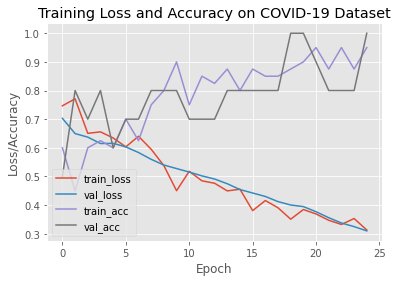

In [22]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# enregistrer la figure
plt.savefig("Trianing_plot")

# afficher la figure
plt.show()

In [21]:
# enregistrer le modèle
model.save("covid_model.h5")
print("[INFO] model saved")

[INFO] model saved
